# Exercise Sheet No. 12

---

> Machine Learning for Natural Sciences, Summer 2023, Jun.-Prof. Pascal Friederich, pascal.friederich@kit.edu
> 
> Container version: 1.0.2
>
> Tutor : Navid Haghmoradi, navid.haghmoradi@kit.edu
---
**Topic**: This exercise sheet will introduce you to bayes optimization and gaussian processes.

**ATTENTION**: Make sure your scipy library is up to date, you can check it running next block,

**Note**: "Avoid using all K_inverse, follow algorithm 2.1 (pag 19) in Rasmussen"

In [22]:
import scipy
scipy.__version__

'1.9.3'

In this exercise we will work on a prototypical implementation of Bayesian Optimization (BayesOpt) based on Gaussian Processes (GP). 

With BayesOpt we denote a class of machine-learning-based optimization methods based on a sequential strategy and designed for black-box derivative-free global optimization. In the following part is the pseudocode of BayesOpt framework:

<div style="background-color:rgba(0, 0, 0, 0.0470588); padding:10px 0;font-family:monospace;">
<p><b>BayesOpt</b></p>
    <b>for</b> n = 1,2,... <b>do</b><br>
    &nbsp;&nbsp;&nbsp;&nbsp;select new $x_{n+1}$ by optimizing acquisition function $\alpha$<br><br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $x_{n+1} = argmax_{x} \alpha(x; \mathcal{D}_{n})$<br><br>
    &nbsp;&nbsp;&nbsp;&nbsp;query objective function to obtain $y_{n+1}$<br>
    &nbsp;&nbsp;&nbsp;&nbsp;augment data $\mathcal{D}_{n+1} = {\mathcal{D}_{n}, (x_{n+1}, y_{n+1})}$<br>
    &nbsp;&nbsp;&nbsp;&nbsp;update surrogate function<br>
    <b>end for</b>
</div>

The BayesOpt framework has the following key elements:
1. the possibility of evaluating the objective function we want to optimize in any given point $x$;
2. a surrogate function, a probabilistic model that captures our beliefs about the behavior of the unknown objective function;
3. an acquisition function, which is used to select next query point and that has to be cheap to evaluate or approximate.


In this notebook we will implement a general BayesOpt framework, GPs as surrogate model and an acquisition function and we will use them to perform hyperparameter optimization on the network you implemented in exercise 6. If you want to know more about BayesOpt a good starting point would be https://ieeexplore.ieee.org/document/7352306.


In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from typing import Tuple, List, Dict, Union, Optional
from matplotlib import cm
from scipy.stats import norm
from scipy.spatial.distance import cdist
from scipy.linalg import cholesky, cho_solve
from scipy.optimize import minimize
from scipy.special import gamma, kv

Vector = List[float]
Matrix = List[List[float]]
Coordinates = Union[Tuple[Vector, Vector], List[Vector]] 

from utils import Kernel, AcquisitionFunc, Regressor, Net, Frame, BayesOpt, Matern52, sobol_sampler, atleast_2d


In the utils file you can find a simple framework (class Frame) to test the classes and function we will be implementing. 

Play around with the input parameters to familiarize with the framework (three 1D functions and one 2D functions were implemented, but the class is easily extendable if you want to give it a try).

observations is a tuple of numpy arrays of shape: x :(8, 1), y : (8,)


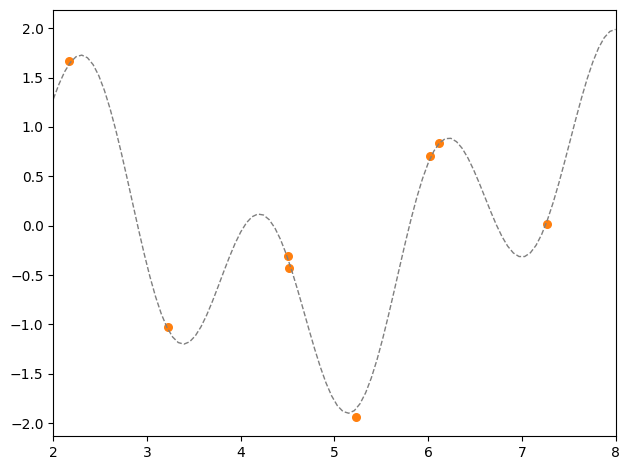

query f() in x = 5.198991709838102 : f(x)=-1.8872141848746526


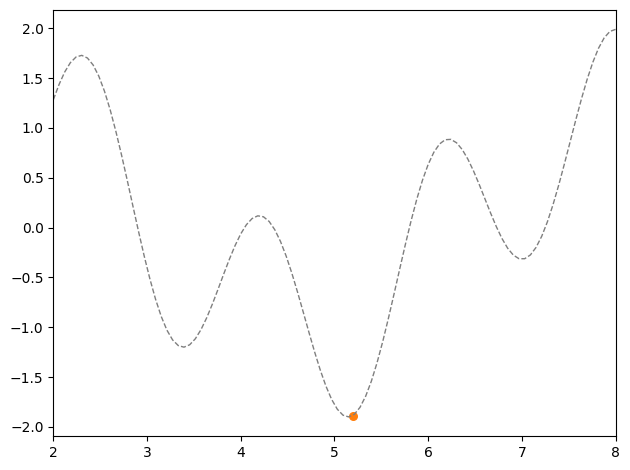

In [24]:
DIM = 1
FUNC = 'func_2'
NOISE_VAR = 0.05
N_SAMPLES = 8

test_framework = Frame(dim=DIM, func=FUNC, noise_var = NOISE_VAR)

## get_samples
observations = test_framework.get_samples(n_samples = N_SAMPLES)
print(f'observations is a tuple of numpy arrays of shape: x :{observations[0].shape}, y : {observations[1].shape}')

## plot
test_framework.plot(samples = observations)

### evaluate
x = np.random.uniform(test_framework.low, test_framework.up, (1, test_framework.dim))
y = test_framework.evaluate(x)
print(f'query f() in x = {x.squeeze()} : f(x)={y.item()}')
test_framework.plot(samples = (x, y))


Our Bayesian optimizer will look something like this (take a look at the full code in the utils.py file):
```python
class BayesOpt:
    def __init__(self, function, surrogate, acquisition, sampler, observations):
        self._function = function
        self._surrogate = surrogate
        self._acquisition = acquisition
        self._sampler = sampler
        self._observations = observations
        
    def run(self, stop_criterion):
        while not stop_criterion:
            self._surrogate.fit(self._observations)
            X_next = self.propose_next()
            Y_next = self._function.evaluate(X_next)
            self._observations.add(X_next, Y_next)
        predictions = self._surrogate.predict(self._observations, self)
        optimal = np.argmin(predictions)
        return self._observations.x[optimal], predictions[optimal]

    def propose_next(self):
        samples = self._sampler()
        vals = self._acquisition(samples)
        best = np.argmax(vals)
        return samples[best]
```

So we will need to implement: 
1. a surrogate model : GP;
2. an acquisition function : Expected Improvement (EI); 
3. a sampler : latin hypercube sampler.

Let's start from our surrogate model: GPs. 

In supervised learning we observe tuples $(x_{i}, y_{i})$ and assume that $y_{i}$ is an observation of some unknown function $f(x_{i})$. The optimal approach to make a prediction given new input would be to infer a distribution over functions given the data $p(f|x_{1:n}, y_{1:n})$ and then marginalize:
<br><p>$p(y|x, x_{1:n}, y_{1:n}) = \int p(y|x, f)p(f|x_{1:n}, y_{1:n})\,df$</p>

A GP defines a prior over functions that can then be converted on a posterior $p(f|x_{1:n}, y_{1:n})$ once some data have been seen. By definition a GP is a collection of random variables, any finite number of which have a joint Gaussian distribution (Rasmussen and Williams, 2006). A GP is completely specified by its mean and covariance functions, where the covariance matrix $\Sigma$ is assumed as given by $\Sigma_{ij}=\kappa(x_{i},x_{j})$, where $\kappa(\cdot,\cdot)$ is a positive definite kernel function. 

We will denote that the prior on the regression function is a GP by: $f(x)$ ~ $GP(\mu(x), \kappa(x, x'))$. It is common to take the mean function to be zero since the GP is flexible enough to model the mean arbitrarily well.

(There is a nice introduction to GPs in chapter 15 of Murphy's "Machine Learning - A Probabilistic Perpective", or, if you want to know more, I suggest you to take a look at "Gaussian Processes for Machine Learning" - Rasmussen and Williams.)


The key element in a GP is the kernel that is used as covariance function. One of the most used kernels is the squared exponential (SE) kernel, also termed Gaussian kernel, defined as:
<br><p>$\kappa(x, x') = exp\,(-\frac{1}{2}(x-x')^T\Sigma^{-1}(x-x'))$</p><br>
(Be careful not to confuse this $\Sigma$ matrix, the kernel's covariance matrix, with the covariance matrix of the GP we met above).<br>
We are going to implement its most straightforward version, the isotropic SE kernel, where the $\Sigma$ matrix is equal to $\sigma^{2} \mathcal{I}$. In this case $\sigma$ is usually termed 'characteristic length scale', in that it can be roughly interpreted as the distance you have to move in the input space before the function value can change significatively. 

Complete the code below to compute, given the input vectors $X_{p}$ and $X_{q}$, the covariance matrix and its gradient with respect to the log-transformed length scale ($\log{\sigma}$), the second of which we will need later when we want to optimize $\sigma$ w.r.t. the input data. Here the formulas you should implement:
<br>$K_{p,q} = \kappa(x_{p}, x_{q}) = exp\,(-\frac{1}{2\cdot length\_scale^{2}}(x_{p}-x_{q})^{2})$<br>
$K\_grad_{p,q} = \frac{\partial K_{p,q}}{\partial (log\_length\_scale)} = \frac{K_{p,q}\cdot(x_{p}-x_{q})^{2}}{length\_scale^{2}}$

The gradient is computed with respect to the log-transformed length scale for the same reason why we did the same in our last exercise: if we optimize w.r.t. $\log{\sigma}$ we have the guarantee that $\sigma_{opt}$ is positive.

Hints: check 'cdist' function from scipy.

If you are curious and want to test other kernels you can easily expand the code, just remember that each implementation must have a __ call__ method and, for each hyperparameter, must store a dictionary of the form: {'name1' : {'value' : value1, 'bounds' : bounds1}} in an attribute named 'hyperparams_name1' (check out also the implementations of Matern kernels in the utils file).

In [25]:
class SE_isotropic(Kernel):
    def __init__(self, length_scale : float = 0.5, length_scale_bounds : Tuple[float] = (1e-2, 1e+1)):
        super().__init__()
        self.length_scale = length_scale
        self.length_scale_bounds = length_scale_bounds

    @property
    def hyperparam_length_scale(self) -> Dict:
        return {'length_scale' : {'value' : self.length_scale, 'bounds' : self.length_scale_bounds}}
        
    def __call__(self, X_p : Vector, X_q : Optional[Vector] = None, compute_grad : bool = False) -> Matrix:
        X_p = atleast_2d(X_p)
        if X_q is None:
            X_q = X_p
        else:
            assert compute_grad is False, 'cannot compute gradient if X_q is not None'
            X_q = atleast_2d(X_q)
            
        distance_matrix = None
        K = None
        # YOUR CODE HERE
        distance_matrix = cdist(X_p, X_q)
        K = np.exp((-1 / (2 * self.length_scale**2)) * (distance_matrix**2))
        #raise NotImplementedError()
        if compute_grad:
            K_grad = None
            # YOUR CODE HERE
            K_grad = (K * (distance_matrix**2)) / self.length_scale**2
            #raise NotImplementedError()
            return K, K_grad
        else:
            return K


In [26]:
# Kernel - 1 point

np.random.seed(1)
kernel = SE_isotropic()
test_framework = Frame()

X, y = test_framework.get_samples(n_samples = 3)
answer = np.array([[1.00000000e+00, 1.32883485e-03, 3.67314625e-06], 
                   [1.32883485e-03, 1.00000000e+00, 6.03368722e-17],
                   [3.67314625e-06, 6.03368722e-17, 1.00000000e+00]])
assert np.isclose(answer, kernel(X)).all(), 'ooops...'

# similar hidden test

Now that we have our kernel we will implement the GP class, but first let's review some theory.

NOISY OBSERVATIONS<br>
We said that the covariance matrix of the GP is determined by the kernel function $\kappa(x, x')$, but this was actually a consequence of the fact that we assumed the observations $y_{i}$ to be noise-free. Let's consider instead the case where our $y_{i}$s are noisy observations of the function $f(\cdot)$ we want to model, i.e. $y_{i} = f(x_{i}) + \epsilon$, where $\epsilon$~$\mathcal{N}(0,\sigma_{y}^{2})$. In this case the covariance associated with our observations will be $K_{y}=K+\sigma_{y}^{2}\mathcal{I}$, where $K$ is determined by a kernel function $\kappa(x,x')$ as usual. What we are enforcing in practice is that our regressor won't have to exactly interpolate our data, but it will just have to pass as close as possible (depending on the value of $\sigma_{y}$) to the observations.

PREDICTIONS<br>
Given a training set $\mathcal{D}=\{(x_{i}, y_{i})\}$ with $i=1,...,N$ and a test set $X_{*}$ we want to predict the objective function $f(X_{*})$, in short $f_{*}$. From the GP definition, and assuming zero-mean for simplicity, follows:
<br>$\begin{pmatrix}f_{*} \\ y\end{pmatrix}$ ~ $\mathcal{N}\Bigg(\begin{pmatrix}0 \\ 0\end{pmatrix}, \begin{pmatrix} K_{**} & K_{*}^T \\K_{*} & K_{y}\end{pmatrix}\Bigg)$<br>
where $K_{*}=\kappa(X, X_{*})$ is $N\times N_{*}$ and $K_{**}=\kappa(X_{*}, X_{*})$ is $N_{*}\times N_{*}$. Then for the theorem about conditional probabilities for Gaussians, the posterior will be:
$p(f_{*}|X_{*}, X, y) = \mathcal{N}(f_{*}|\mu_{*}, \Sigma_{*})$
$\mu_{*} = K_{*}^T K_{y}^{-1} y$
$\Sigma_{*} = K_{**} - K_{*}^T K_{y}^{-1} K_{*}$

FIT<br>
Both kernel parameters and $\sigma_{y}$ can be optimized with respect to the observed data. This is not strictly necessary for the exercise but for completeness I will say en passant that we will take an empirical Bayes approach and use a continuous optimization method. Check the code or paragraph 15.2.4 of Murphy's textbook if you want to know more.

A REMARK ON COMPUTATIONAL STABILITY<br>
From the formulas above you have seen that for prediction (and actually for fitting the GP to the data) we need $K_{y}^{-1}$. For numerical stability it is unwise to directly invert the $K$ matrix. More robust approaches would be to compute a Cholesky decomposition of $K$, i.e. $K=LL^{T}$ with $L$ a lower triangular matrix, and than solve $\alpha = K_{y}^{-1} y = L^{-T}L^{-1}y$ or to solve $\alpha = K_{y}^{-1} y$ using conjugate gradients (CG). With this second approach modulating the number of iterations of the CG algorithm we can tradeoff the time complexity with the level of approximation on the estimation of $\alpha$. 




<br><br><b>EXERCISE INSTRUCTIONS</b><br>
In the following box you will have to complete the implementation of <b>three</b> functions: 
1. <b>_compute_K</b>, which returns the matrix $K_{y} = K+\sigma_{y}^{2}\mathcal{I}$
2. <b>_invert</b>, which takes $K$ as input and inverts it (I suggest to use Cholesky decomposition but it is not mandatory)
3. <b>predict</b>, you will have to complete the computation of the posterior mean $\mu_{*}$ and covariance $\Sigma_{*}$ as in the equations above.

Hints: in case you opted for Cholesky decomposition check scipy 'cho_solve' and 'cholesky' functions (already imported).

In [45]:
class GP(Regressor):
    '''
    GP regressor for 1d observations
    '''
    def __init__(self, kernel : Kernel, noise_sigma : float = 0.1, noise_bounds = (0.01, 0.3)):
        self.kernel = kernel
        self._noise_sigma = noise_sigma
        self._noise_bounds = noise_bounds
        self._obs = None
        self._obs_scaler = 0
        self._K = None
        
    @property
    def noise(self):
        return np.log(self._noise_sigma)

    @noise.setter
    def noise(self, noise_sigma : float):
        self._noise_sigma = np.exp(noise_sigma)

    @property
    def noise_bounds(self):
        return tuple(np.log(self._noise_bounds))

    def _compute_K(self, obs : Optional[Coordinates] = None):
        if obs is not None:
            self._obs = obs
        self._K = None   # two terms: one is the kernel function, the other the noise associated with the observation process
        # YOUR CODE HERE
        self._K = self.kernel(self._obs[0]) + self._noise_sigma**2 * np.eye(len(self._obs[0]))
        # raise NotImplementedError()
        
    @staticmethod
    def _invert(K : Matrix) -> Matrix:
        '''
        3 options:
         - directly invert (this could give errors in other parts of the exercise)
         - invert solving system after cholesky decomposition   <----   strongly suggested!
         - conjugate gradients on system (time complexity is tunable)
        '''
        Kinv = None
        # YOUR CODE HERE
        L = cholesky(K, lower=True)
        Kinv = cho_solve((L,True), np.eye(K.shape[0]))
        #Kinv = Kinv.T.dot(Kinv)
        #raise NotImplementedError()
        return Kinv

    def _nll(self, theta : List[float], compute_grad : bool = True) -> float:
        '''
        negative log marginal likelihood and gradients
        '''
        self.kernel.theta = theta[:-1]
        self.noise = theta[-1]
        if compute_grad:
            K, K_grad = self.kernel(self._obs[0], compute_grad=True)
        else:
            K = self.kernel(self._obs[0])
        K += self._noise_sigma**2 * np.eye(K.shape[0])
        L = cholesky(K, lower=True)
        alpha = cho_solve((L, True), self._obs[1])
        l_likelihood = -.5 * self._obs[1].dot(alpha) - np.log(np.diag(L)).sum() - len(K)*.5*np.log(2*np.pi)

        if compute_grad:
            dummy = np.einsum('i,j->ij', alpha, alpha) - self._invert(K)
            # directly compute trace
            l_likelihood_grad = [-.5*dummy.ravel().dot(K_grad.T.ravel())]
            # add noise
            l_likelihood_grad.append(-dummy.ravel().dot((self._noise_sigma*np.eye(K.shape[0])).ravel()))

            return -l_likelihood, l_likelihood_grad
        else: 
            return -l_likelihood

    def fit(self, obs : Coordinates, optimizer : str = 'L-BFGS-B', n_restarts : int = 40, verbose : bool = False):
        '''
        only for bounded minimization
        '''
        assert obs[0].size != 0, 'cannot fit model if no observations are provided'
        self._obs_scaler = np.min(obs[1])
        self._obs = (obs[0], obs[1] - self._obs_scaler)
        def objective_func(theta):
            return self._nll(theta)
        theta_opt, func_min = [], []
        for i in range(n_restarts):
            bounds = [tuple(b) for b in self.kernel.bounds]
            bounds.append(self.noise_bounds)
            if i > 0:
                temp = [np.random.uniform(b[0], b[1]) for b in bounds]
                gp.kernel.theta = temp[:-1]
                gp.noise = temp[-1]

            theta = self.kernel.theta
            theta = np.append(theta, self.noise)
            opt_res = minimize(objective_func, theta, method=optimizer, jac=True, bounds=bounds)
            theta_opt.append(opt_res.x)
            func_min.append(opt_res.fun)
        best = np.argmin(func_min)
        if verbose:
            print(f'Nll minimum : {func_min[best]}, optimal hyperparameters : {np.exp(theta_opt[best])}')
        self.kernel.theta = theta_opt[best][:-1]
        self.noise = theta_opt[best][-1]
        self._compute_K()

    def sample_functions(self, X, n_functions : int = 1, plot : bool = True):
        Ks = self.kernel(self._obs[0], X)
        Kss = self.kernel(X)
        Kinv = self._invert(self._K) 
        mean = Ks.T.dot(Kinv).dot(self._obs[1])
        covariance = Kss - Ks.T.dot(Kinv).dot(Ks)

        samples = np.random.multivariate_normal(mean, covariance, n_functions)
        if plot and len(X.shape) < 2:
            fig, ax = plt.subplots()
            ax.scatter(self._obs[0], self._obs[1], marker="o", s=50, c="C1")
            for i in range(samples.shape[0]):
                ax.plot(X.squeeze(), samples[i, :], lw=1, ls='--')
            #plt.savefig('samples_Wtrain_noise'+str(self._noise_sigma)+'.png')
            plt.show()
            plt.close()
        return samples

    def predict(self, X : Coordinates, compute_std : bool = True, compute_covariance : bool = False):
        assert not(compute_std and compute_covariance), 'choose at most one among std and covariance'
        Ks = self.kernel(self._obs[0], X)
        Kinv = self._invert(self._K) 
        mean = None   
        # YOUR CODE HERE
        mean = Ks.T.dot(Kinv).dot(self._obs[1])
        # raise NotImplementedError()
        if compute_covariance:
            Kss = self.kernel(X)
            cov = None 
            # YOUR CODE HERE
            cov = Kss - Ks.T.dot(Kinv).dot(Ks)
            # raise NotImplementedError()
            return mean + self._obs_scaler, cov

        elif compute_std:
            dummy = Kinv.dot(Ks)
            var = np.diag(self.kernel(X)).copy()
            var -= np.einsum("ji,ji->i", Ks, dummy)
            var[var<0] = 0 # there could be negative variances because of computational errors
            return mean + self._obs_scaler, np.sqrt(var)
        else:
            return mean + self._obs_scaler

In [35]:
# compute_K - 1 point
kernel = Matern52()
gp = GP(kernel=kernel)
test_framework = Frame(dim = 1, func = 'func_2')

np.random.seed(12)
observations = test_framework.get_samples(n_samples = 2)
gp._compute_K(observations)
answer = np.array([[1.01000000e+00, 1.47418222e-05],
                   [1.47418222e-05, 1.01000000e+00]])
assert np.isclose(gp._K, answer).all(), 'ooops...'

# similar hidden test

In [46]:
# invert - 1 point
kernel = Matern52()
gp = GP(kernel=kernel)

K = np.array([[1, 1],
              [1, 5]])
Kinv = np.array([[ 1.25, -0.25],
                 [-0.25,  0.25]])
print(gp._invert(K))
assert np.isclose(gp._invert(K), Kinv).all(), 'ooops...'

# similar hidden test

[[1.     0.    ]
 [0.     0.0625]]


AssertionError: ooops...

In [ ]:
# predict - 1 point

test_framework = Frame(dim = 1, func = 'func_2')
kernel = Matern52()
gp = GP(kernel=kernel)

np.random.seed(12)
observations = test_framework.get_samples(n_samples = 4)
gp._compute_K(observations)
val, cov = gp.predict(X=np.array([5, 6]), compute_covariance=True, compute_std=False)
true_val = np.array([-1.6872044,  -0.10250491])
true_cov = np.array([[ 0.23048763, -0.06465079],
                     [-0.06465079,  0.6058542 ]])
assert np.isclose(val, true_val).all() and np.isclose(cov, true_cov).all(), 'ooops...'

# similar hidden test

Let's have a look at the effect of the kernel parameters on the GP.

As stated above the length scale controls the horizontal scale over which the function changes. Given a set of observations let's see what the predictions of the GP will be varying the kernel parameters. 

(If you had problems implementing the SE kernel you can use Matern52 or Matern32 kernels from the utils file.)

In [ ]:
np.random.seed(6)

test_framework = Frame(dim = 1, func = 'func_2')
observations = test_framework.get_samples(n_samples = 10)
upper_limit = test_framework.up
lower_limit = test_framework.low
length_scale_bounds = ((upper_limit - lower_limit)/10, upper_limit/2)

print('Plotting the observations and the ground truth')
test_framework.plot(samples = observations)
for length_scale in [1, 0.5, 0.1]:
    print('LENGTH SCALE = ', length_scale)
    kernel = SE_isotropic(length_scale, length_scale_bounds) 
#     kernel = Matern52(length_scale, length_scale_bounds) 
    gp = GP(kernel=kernel)
    gp._compute_K(observations)
    X = np.linspace(lower_limit, upper_limit, 100)
    print('\t Plotting 3 sample functions from the GP posterior')
    samples = gp.sample_functions(X, n_functions = 3)
    print('\t Plotting mean and 2*std confidence bounds of GP posterior')
    test_framework.plot(surrogate = gp, samples = observations)
    
print("Finally let's try to fit our GP on the observed data")
print('First of the optimal parameters is the length scale, second is the observation noise')
gp.fit(observations, verbose=True)
test_framework.plot(surrogate = gp, samples = observations)

As you can notice from the plots, increasing the length scale the ensemble of functions represented by the GP gets smoother but the interpolation of observed data gets worse. Fitting the GP to the data means trying to balance the trade off between these two behaviours. 

This is a general problem in Machine Learning and is usually referred to as the <b>bias/variance</b> tradeoff. In our case a small length scale means high variance, a large length scale a large bias. A similar reasoning can be made for the $\sigma_{y}$, think about it (and test if you are curious).

We have our probabilistic model, a.k.a. surrogate function, which represents our prior belief over the possible objective functions and we now want to refine this model by observing new data: after observing the output of each query of the objective, the prior is updated to produce a more informative posterior distribution over the space of objective functions.

Then, how do we select where to observe the function next? 

The approach in Bayesian optimization is to design an acquisition function, which is typically an inexpensive function that "measures" how desirable evaluating $f(\cdot)$ in $x$ is expected to be for the maximization problem and for refining our probabilistic model. In short, we are replacing our original optimization problem with another optimization problem, but on a much cheaper function.

There are many acquisition functions that are currently used in BayesOpt. Just to name a few: upper confidence bound (UCB), probability of improvement (PI), expectation improvement (EI), Thompson sampling (TS), knowledge gradient (KG), entropy search (ES) and predictive entropy search (PES). 

We will try to figure out what kind of behaviour we would desire from our acquisition function using UCB as an example, then we will try to implement EI.

But just before that, we have to make an aside. As it could be computationally expensive, we could not calculate the acquisition function for all points, and then conclude that: OK, LETS FIND THE "Y" VALUE IN THIS POINT!!!. Among the various approaches we can take to find the maximum of the acquisition function we will opt for a simple method: we will sample random points in our design space $\mathcal{X}$, compute the acquisition function in each point and select its maximum. Thus we need an efficient way to randomly sample from the domain, where efficient means that we need to cover as much volume as possible in the least number of samples. More formally: we want our set of samples to be a low-discrepancy sequence. 

Simply sampling from a uniform distribution doesn't guarantee that the discrepancy will be low, but many methods are available. We will implement a simple method which is often used for Monte Carlo integration, the latin hypercube sampling.

A Latin square is a square grid of the sample space $\mathcal{S}$ containing one and only one sample in each row and each column, as shown in the following picture.
<img src="LS.png" alt="drawing" width="150"/>

A Latin hypercube is its generalization when $|\mathcal{S}| > 2$, whereby each sample is the only one in each axis-aligned hyperplane containing it. The procedure to get the samples is quite easy. For $N$ samples in a $D$-dimensional sample space: divide each dimension in N equal intervals, draw randomly a sample from each of the $N^{D}$ hypercubes.

Try to implement LHS in the box below (you can implement it as you prefer, my comments are just a suggestion)

In [ ]:
def latin_hypercube_sampler(dim : int, n_samples : int):
    # build a grid, dividing each dimension in n_samples subintervals
    # permute randomly dimension-wise
    grid = None     # grid.shape = (n_samples, dim)
    # sample n_samples*dim random offsets from a uniform distribution 
    offsets = None  # offsets.shape = grid.shape
    # sum the offsets to the grid to produce our sequence of samples
    samples = None
    
    # YOUR CODE HERE
    raise NotImplementedError()
    return samples[:, np.newaxis, :]


In [ ]:
# sampler - 1 point
assert latin_hypercube_sampler(dim=2,n_samples=3).shape == (3,1,2)

# hidden test to check if samples represent a latin hypercube

Let's compare our LHS with uniformly drawn samples and Sobol sequences. Sobol sequences are quasi-random low-discrepancy sequences, a little tricky to implement but, as you will see running the code below, they converge very fastly to equidistribution.  

In [ ]:
np.random.seed(2)
for n in [32, 64, 256]:
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharex='all', figsize=(15, 5))
    lat_samples = latin_hypercube_sampler(dim=2,n_samples=n).squeeze()
    unif_samples = np.random.rand(n, 2)
    sob_samples = sobol_sampler(dim=2,n_samples=n).squeeze()
    ax1.scatter(unif_samples[:,0], unif_samples[:,1])
    ax1.set_title('Random Uniform')
    ax2.scatter(lat_samples[:,0], lat_samples[:,1])
    ax2.set_title('LHS')
    ax3.scatter(sob_samples[:,0], sob_samples[:,1])
    ax3.set_title('Sobol Sequence')
    fig.tight_layout()
    plt.show()
    plt.close()

We can now turn back to the acquisition functions. 

Two straightforward ideas would be: 
1. be cautious -> query the objective function where our current model has the highest uncertainty;
2. be greedy -> query the objective function at the maximum of our current model.

The problem of deciding which of these two approaches to take is well known in reinforcement learning and it is usually referred to as the <b>exploration VS exploitation</b> problem. In the code below you can find a naive implementation of both methods. (Run the cell, we will need it)


In [ ]:
class Cautious(AcquisitionFunc):
    def __call__(self, X : Coordinates, model : Regressor, *args) -> float:
        _, sigma = model.predict(X)
        return sigma
    
    def __repr__(self):
        return 'Cautious'

    
class Greedy(AcquisitionFunc):
    def __call__(self, X : Coordinates, model : Regressor, *args) -> float:
        mean = model.predict(X, compute_std = False)
        return -mean # there is a minus here because what we actually want is to minimize our obj function
    
    def __repr__(self):
        return 'Greedy'

We could try to be more flexible by maximizing a linear combination of the predicted value and the confidence in the prediction. To do so we simply introduce another parameter that we use to regulate the tradeoff between these two terms: we have just invented the Upper Confidence Bound acquisition function.

Unfortunately other people thought about this before us, so no publication...
(Remember to run the box below)

In [ ]:
class Upper_Confidence_Bound(AcquisitionFunc):
    def __init__(self, tradeoff : float = 1):
        super().__init__()
        self.tradeoff = tradeoff

    def __call__(self, X : Coordinates, model : Regressor, *args) -> float:
        mean, sigma = model.predict(X)
        return - mean + self.tradeoff * sigma
    
    def __repr__(self):
        return f'UCB with tradeoff = {self.tradeoff}'

Running the code below we will test the behaviour of our acquisition functions: in blue we plot the acquisition function, the selected next point to query (maximum of acq. function) is plotted in the graph above in red. 

As you can notice the UCB generates a behaviour that is an intermediate between the completely explorative or completely exploitative approaches. Try to modify the tradoff parameter and see what happens.

(If you had any problem implementing latin hypercube sampler (LHS) or SE kernel you can use Sobol sampler and Matern kernel)

In [ ]:
# SET FRAMEWORK
np.random.seed(5)
test_framework = Frame(dim = 1, func = 'func_1')
observations = test_framework.get_samples(n_samples = 3)
upper_limit = test_framework.up
lower_limit = test_framework.low
length_scale_bounds = ((upper_limit - lower_limit)/6, upper_limit/2)
kernel = SE_isotropic(length_scale_bounds = length_scale_bounds)
#kernel = Matern52(length_scale_bounds = length_scale_bounds)
gp = GP(kernel=kernel)
gp.fit(observations)

# SET ACQUISITION FUNCTIONS AND SAMPLER
cautious = Cautious() 
greedy = Greedy()
ucb = Upper_Confidence_Bound(tradeoff=2)
samples = latin_hypercube_sampler(dim=1, n_samples=32) 
# samples = sobol_sampler(dim=1, n_samples=32)

# RUN
for acquisition in [cautious, greedy, ucb]:
    samples_scaled = []
    acq_values = []
    for sample in samples:
        sample = sample * (upper_limit - lower_limit) + lower_limit
        val = acquisition(sample, gp)
        acq_values.append(val)
        samples_scaled.append(sample)
    best = np.argmax(acq_values)
    print(f'acquisition function : {acquisition}')
    test_framework.plot(surrogate = gp, samples = observations, 
                        acquisition = (samples_scaled, acq_values), 
                        minimum = (samples_scaled[best], gp.predict(samples_scaled[best], compute_std=False)))

UCB is easy to understand and implement but has a major drawback: the optimality of the tradeoff parameter is strongly problem dependent. We are trying to build a framework (BayesOpt) that will allow us to automatically optimize some parameters but in doing so we have introduced another free parameter that we have to tune.

We will try now to implement a quite popular acquisition function that solves this problem: the Expected Improvement (EI).

Assume $f'$ is the minimal value of $f$ observed so far, i.e. $f'= \min_{i=1:N} f(x_{i})$. EI evaluates $f$ at the point that, in expectation, improves upon $f'$ the most, i.e. we want to maximize the expectation of the utility function $u(x) = \max (0, f' - f(x))$. In formula:
<br>$\alpha_{EI}(x) = \mathbb{E}[u(x)|\mathcal{D}] = \int_{-\infty}^{f'} (f' - f)\mathcal{N}(f; \mu, \sigma^{2}) \,df$
$= (f' - \mu)\Phi(f';\mu.\sigma^{2}) + \sigma\mathcal{N}(f';\mu, \sigma^{2})$

The first of these two terms can be interpreted as an exploitation term  while the second an exploration one and the trade off between these two is captured "automatically" by this criterion.

Hints: take a look at norm.cdf and norm.pdf functios in scipy.stats ('norm' is already imported)

In [ ]:
class Expected_Improvement(AcquisitionFunc):
    def __call__(self, X : Coordinates, model : Regressor, obs : Optional[Coordinates] = None) -> float:
        if obs is not None:
            actual_opt = np.min(model.predict(obs, compute_std = False)) 
        else:
            actual_opt = 0
        mean, sigma = model.predict(X)
        sigma = sigma.reshape(-1,1)
        
        value = None
        # YOUR CODE HERE
        raise NotImplementedError()
        return value


In [ ]:
# acquisition - 1 point
np.random.seed(6)
test_framework = Frame()
observations = test_framework.get_samples(n_samples = 3)
upper_limit = test_framework.up
lower_limit = test_framework.low
length_scale_bounds = ((upper_limit - lower_limit)/6, upper_limit/2)

kernel = Matern52(length_scale_bounds = length_scale_bounds)
gp = GP(kernel=kernel)
gp.fit(observations)
acquisition = Expected_Improvement()

assert np.isclose(acquisition(np.array([2]), gp), 0.62150429), 'Error in EI implementation'

# hidden test (another check on EI value)

We have now everything we need for our Bayesian optimization framework, you can find the BayesOpt class in the utils file. 

We will test it first on our toy problems. 
<br>Try it out on different datasets (read comments next to uppercase variables).



In [ ]:
np.random.seed(113)

EPOCHS = 10
DIM = 1 # or 2 (for 2 dimensions only with 'func_1' was implemented)
FUNC = 'func_2' # or 'func_1', or 'func_3'

# set framework
test_framework = Frame(dim = DIM, func = FUNC)
observations = test_framework.get_samples(n_samples = 1)
upper_limit = test_framework.up
lower_limit = test_framework.low
length_scale_bounds = ((upper_limit - lower_limit)/EPOCHS, upper_limit/2)

test_framework.plot(samples = observations)

# set surrogate model
# kernel = SE_isotropic(length_scale_bounds = length_scale_bounds)
kernel = Matern52(length_scale_bounds = length_scale_bounds)
gp = GP(kernel=kernel)

# set acquisition funciton
ei = Expected_Improvement()
#ucb = Upper_Confidence_Bound(tradeoff = 2)

# set BayesOpt and run 
optimizer = BayesOpt(function = test_framework, 
                     surrogate = gp, 
                     bounds = {'lower': lower_limit, 'upper': upper_limit}, 
                     acquisition = ei, #ucb 
                     sampler = latin_hypercube_sampler, #sobol_sampler,
                     observations = observations, 
                     n_samples = 1024
                    )

opt_res = optimizer.run(epochs = EPOCHS, plot_steps = True)

# print results
print(f'optimal noise value :{np.exp(optimizer._surrogate.noise)}, optimal kernel parameters :{optimizer._surrogate.kernel.hyperparams}')

print(f'minimum value : {opt_res[1]} found in position : {opt_res[0]}')

Finally we can use our GP-based BayesOpt implementation to tune some of the hyperparameters of the simple MLP you implemented for exercise 6 (check the 'Net' class in the utils file): 
1. the number of hidden units;
2. the learning rate;
3. the batch size.

For each evaluation we are training the network for 5 epochs only (otherwise it would take a long time to run this) but you can notice how performance already improves a lot w.r.t. the results we had simply setting the hyperparameters to reasonable values (just as a reminder, in exercise 6 we scored 0.33 for the LUMO). 

> If in any case, here, importing the necessary libraries shows some problem, please post it online in the forum and send an email to me. navid.haghmoradi@gmail.com

In [ ]:
np.random.seed(34)

EPOCHS = 5

test_framework = Net()
observations = test_framework.get_samples(n_samples = 1)
upper_limit = test_framework.up
lower_limit = test_framework.low
length_scale_bounds = ((upper_limit - lower_limit)/EPOCHS, upper_limit/2)

kernel = SE_isotropic(length_scale_bounds = length_scale_bounds)
#kernel = Matern52(length_scale_bounds = length_scale_bounds)

gp = GP(kernel=kernel)

ei = Expected_Improvement()
#ucb = Upper_Confidence_Bound(tradeoff = 2)

optimizer = BayesOpt(function = test_framework, 
                     surrogate = gp, 
                     bounds = {'lower': lower_limit, 'upper': upper_limit}, 
                     acquisition = ei, #ucb, 
                     sampler = latin_hypercube_sampler, #sobol_sampler,
                     observations = observations, 
                     n_samples = 1024
                    )
opt_res = optimizer.run(epochs = EPOCHS)

hp = test_framework._scale(opt_res[0])
print(f'maximum r2_score : {-opt_res[1]} found for : {{ hidden units : {hp[0]}, lr : {np.round(hp[1], 4)}, batch size : {hp[2]} }}')
